# **Graded Challenge 7: Sarcasm Detection**

Farhan Falahaqil Rafi

FTDS-003-BSD

# **Introduction**

## **Project Overview**

This project explores the domain of sarcasm detection in text data, a challenging yet intriguing aspect of Natural Language Processing (NLP). The focus is on classifying headlines as sarcastic or non-sarcastic, using the advanced BERT (Bidirectional Encoder Representations from Transformers) model.

## **Objectives**

The primary objectives of this project are:

1. **Understanding and Implementing BERT**: Employ BERT as the base model for this text classification task, gaining insights into its architecture and applicability in NLP.
2. **Framework Comparison**: Investigate the model's performance using both TensorFlow and PyTorch, addressing the challenges faced with CUDA compatibility in TensorFlow.
3. **Sarcasm Detection**: Accurately classify headlines, enhancing the model's ability to discern subtle nuances in language indicative of sarcasm.
4. **Model Performance Analysis**: Analyze and compare the model's effectiveness across different frameworks, focusing on aspects like accuracy, computational efficiency, and scalability.

## **Dataset Description**


The dataset for this project consists of headlines sourced from various news articles, labeled for sarcasm detection. Each entry includes:

- `headline`: The textual content of the news headline.
- `is_sarcastic`: A binary label indicating sarcasm (`1` for sarcastic, `0` for non-sarcastic).
- `article_link`: The URL to the original news article.

This rich dataset provides a varied and extensive set of examples for training and evaluating the BERT model in the context of sarcasm detection.

# **Import Libraries**

In [40]:
# Data manipulation and mathematical computations
import pandas as pd
import numpy as np
import json

# Visualization libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Text analysis libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
import textstat

# Transformers library for BERT model
from transformers import BertTokenizer, BertForSequenceClassification, TFBertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# PyTorch libraries for deep learning
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from torch.nn.utils import clip_grad_norm_

# TensorFlow libraries for deep learning
import tensorflow as tf
from tensorflow.keras.optimizers import Adam


# **Data Loading**

In this section, we begin by loading our dataset. The dataset is stored in a JSON format, which requires us to read each line as a separate JSON object and then compile them into a DataFrame for easier manipulation and analysis.

In [2]:
# Attempt to read the file line by line as multiple JSON objects
data = []
with open('Sarcasm_Headlines_Dataset_v2.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

## **Dataset Structure and Info**

Once the data is loaded into a DataFrame, it's crucial to understand its structure and the type of information it contains. We use `df.info()` to get a concise summary of the DataFrame, including the number of non-null values in each column and the data type of each column.

In [3]:
# Displaying dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB



## **Analyzing the Target Variable**

A key aspect of our dataset is the distribution of the target variable `is_sarcastic`. Understanding this distribution helps in assessing the balance in our dataset, which is crucial for training unbiased models.


In [4]:
# Displaying target variable count
df.is_sarcastic.value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64


## **Checking for Duplicates**

Duplicate entries can skew our analysis and model training. Therefore, identifying and removing duplicates is an essential step in preparing our dataset.

In [5]:
# Displaying duplicate count
df.duplicated().sum()

2

## **Cleaning the Data**

After identifying duplicates, we proceed to clean the data by removing these duplicate entries. This ensures the integrity and uniqueness of our dataset.

In [6]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

In [7]:
# Displaying number of duplicates
df.duplicated().sum()

0

## **Preliminary Data Analysis**

Before delving into model building, some preliminary analysis is done. This includes checking for missing values and analyzing the distribution of the target variable. Additionally, we explore the average length of text in our headlines, differentiated by whether they are sarcastic or not. These insights provide valuable context for our feature engineering and model training phases.

In [8]:
# Check for Missing Values
missing_values = df.isnull().sum()

# Distribution of Target Variable
target_distribution = df['is_sarcastic'].value_counts()

# Text Length Analysis
df['text_length'] = df['headline'].apply(len)
average_length = df.groupby('is_sarcastic')['text_length'].mean()

# Prepare the results to display
results = {
    'Missing Values': missing_values,
    'Target Distribution': target_distribution,
    'Average Text Length by Target': average_length
}

results

{'Missing Values': is_sarcastic    0
 headline        0
 article_link    0
 dtype: int64,
 'Target Distribution': is_sarcastic
 0    14984
 1    13633
 Name: count, dtype: int64,
 'Average Text Length by Target': is_sarcastic
 0    59.560798
 1    65.331035
 Name: text_length, dtype: float64}

**Preliminary Data Analysis Insights**

Our initial analysis of the dataset reveals several key insights:

1. **No Missing Values**: The dataset is complete with no missing values across all columns (`is_sarcastic`, `headline`, `article_link`). This is an ideal scenario, as it eliminates the need for imputation strategies that could potentially introduce bias or inaccuracies.

2. **Balanced Target Distribution**: The target variable `is_sarcastic` shows a fairly balanced distribution with 14,984 non-sarcastic (`0`) and 13,633 sarcastic (`1`) headlines. This balance is beneficial for model training, as it reduces the risk of bias towards the more frequent class.

3. **Text Length Variation**: There is a noticeable difference in the average length of sarcastic vs. non-sarcastic headlines. Sarcastic headlines have a higher average length (approximately 65.33 characters) compared to non-sarcastic ones (around 59.56 characters). This suggests that sarcastic headlines might be slightly more complex or detailed, potentially providing more contextual cues for sarcasm detection.

These insights set a strong foundation for the subsequent stages of our analysis, including feature engineering and model building, where we'll leverage these characteristics to enhance model performance.

# **Exploratory Data Analysis**

## **Word Cloud**

A word cloud is a visual representation where the frequency of word occurrence in a text dataset is depicted with size. In this analysis:

- **Purpose**: To visually identify the most frequently occurring words in the dataset.
- **Method**: Words that appear more often in the dataset are displayed in larger fonts, making it easy to spot common themes or topics in sarcastic vs. non-sarcastic headlines.

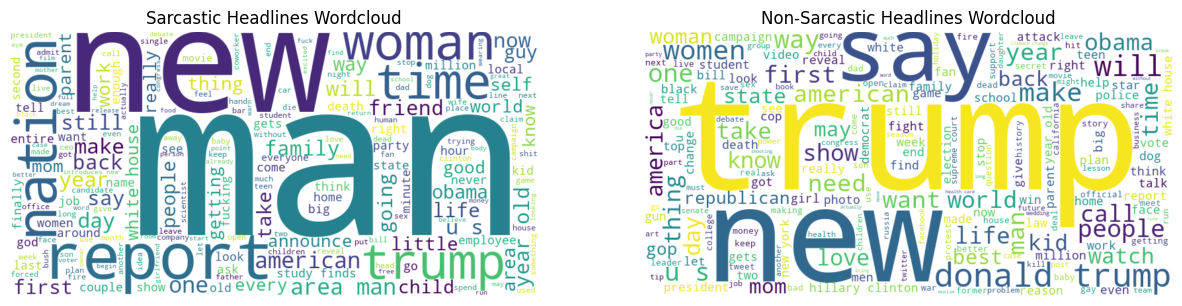

In [9]:
# Wordcloud for Sarcastic Headlines
sarcastic_headlines = ' '.join(df[df['is_sarcastic'] == 1]['headline'])
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_headlines)

# Wordcloud for Non-Sarcastic Headlines
non_sarcastic_headlines = ' '.join(df[df['is_sarcastic'] == 0]['headline'])
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_headlines)

# Plotting the word clouds
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Headlines Wordcloud')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Headlines Wordcloud')
plt.axis('off')

plt.show()


- **Sarcastic Headlines**: The frequent appearance of words like "new," "man," "nation," "report," "woman," "time," and "Trump" in sarcastic headlines suggests a focus on current events and social commentary. The presence of "Trump" indicates political satire might be a common theme.

- **Non-Sarcastic Headlines**: The word "Trump" also being prominent here, along with "new," "say," "will," "first," "way," "women," "call," and "love," indicates a strong focus on current affairs and personal stories. The overlap of words like "Trump" and "new" in both categories suggests these topics are common but likely approached differently.

## **N-Gram**

N-grams are continuous sequences of 'n' items from a given sample of text or speech. Here, we've used bi-grams (sequences of two words) and tri-grams (sequences of three words):

- **Purpose**: To identify common word pairs or triplets in the dataset, which can highlight prevalent language patterns or phrases.
- **Method**: This analysis helps in understanding how words are typically combined in sarcastic and non-sarcastic contexts, offering insights into the style and structure of the language used.

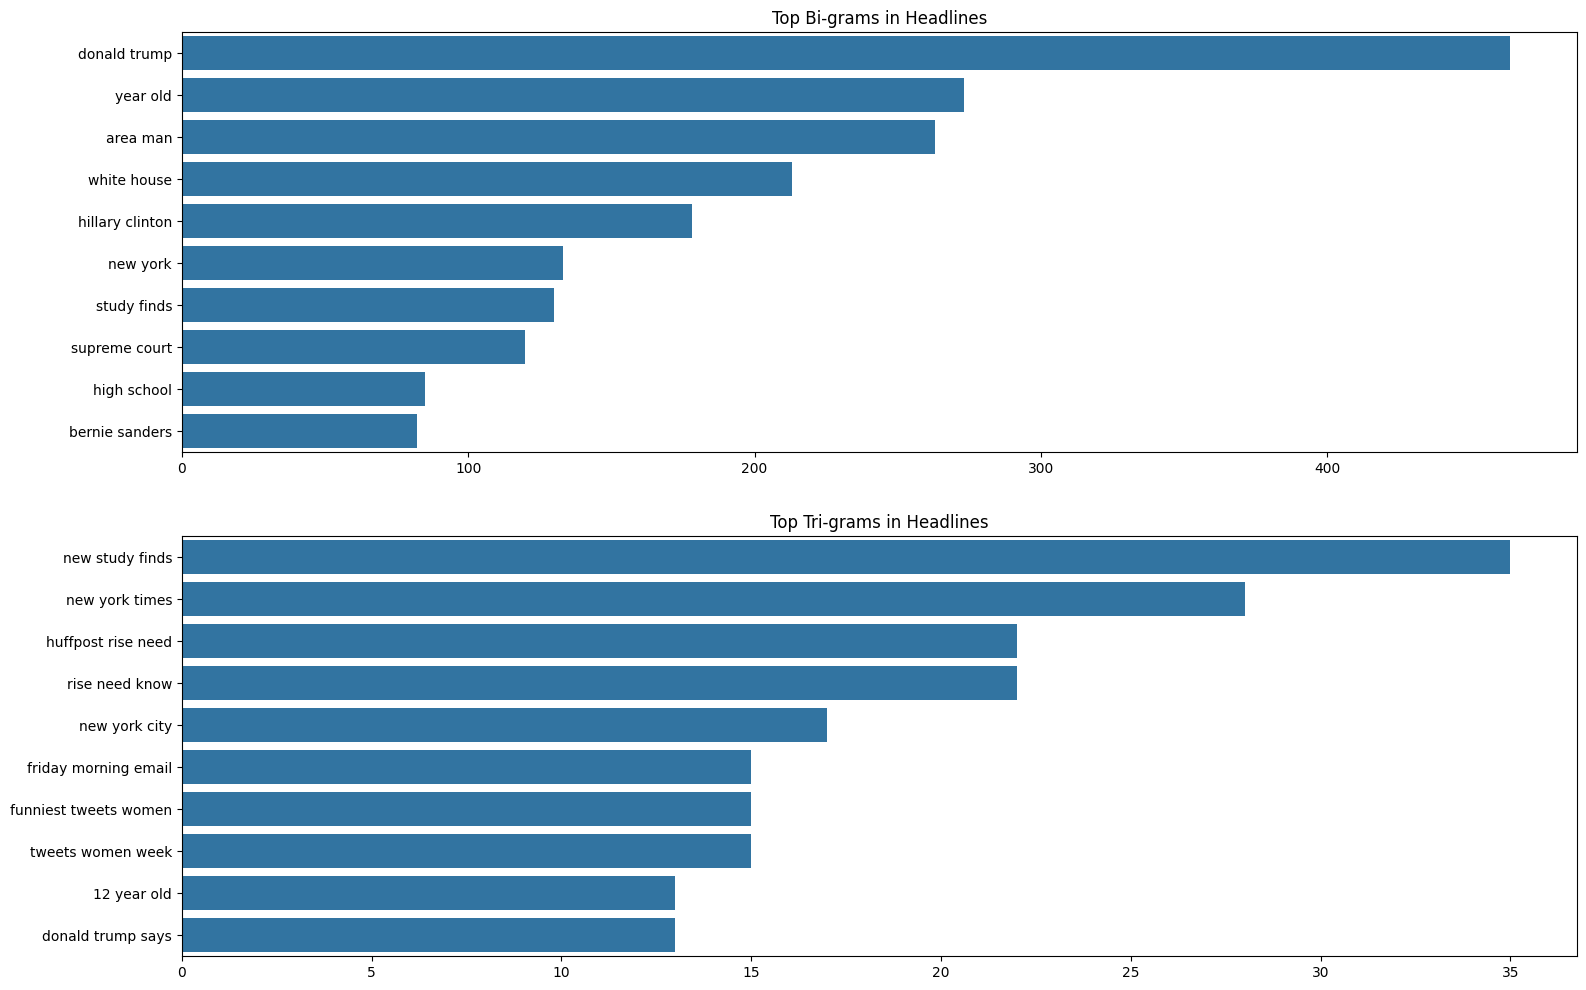

In [10]:
# Function to plot top N-grams
def plot_top_ngrams(text, n=2, top_k=10, title="Top N-Grams"):
    """Plot the top N n-grams in the provided text."""
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_ngrams = words_freq[:top_k]

    x, y = map(list, zip(*top_ngrams))
    sns.barplot(x=y, y=x).set_title(title)

# N-Gram Analysis (Bi-grams and Tri-grams)
plt.figure(figsize=(18, 12))
plt.subplot(2, 1, 1)
plot_top_ngrams(df['headline'], n=2, title="Top Bi-grams in Headlines")

plt.subplot(2, 1, 2)
plot_top_ngrams(df['headline'], n=3, title="Top Tri-grams in Headlines")

plt.show()


- **Bigrams and Trigrams**: The presence of "Donald Trump," "Hillary Clinton," "White House," and similar phrases across both sarcastic and non-sarcastic headlines indicates a heavy focus on political topics. However, sarcastic headlines might use these phrases in a more ironic or satirical context.

## **Separated N-Grams**

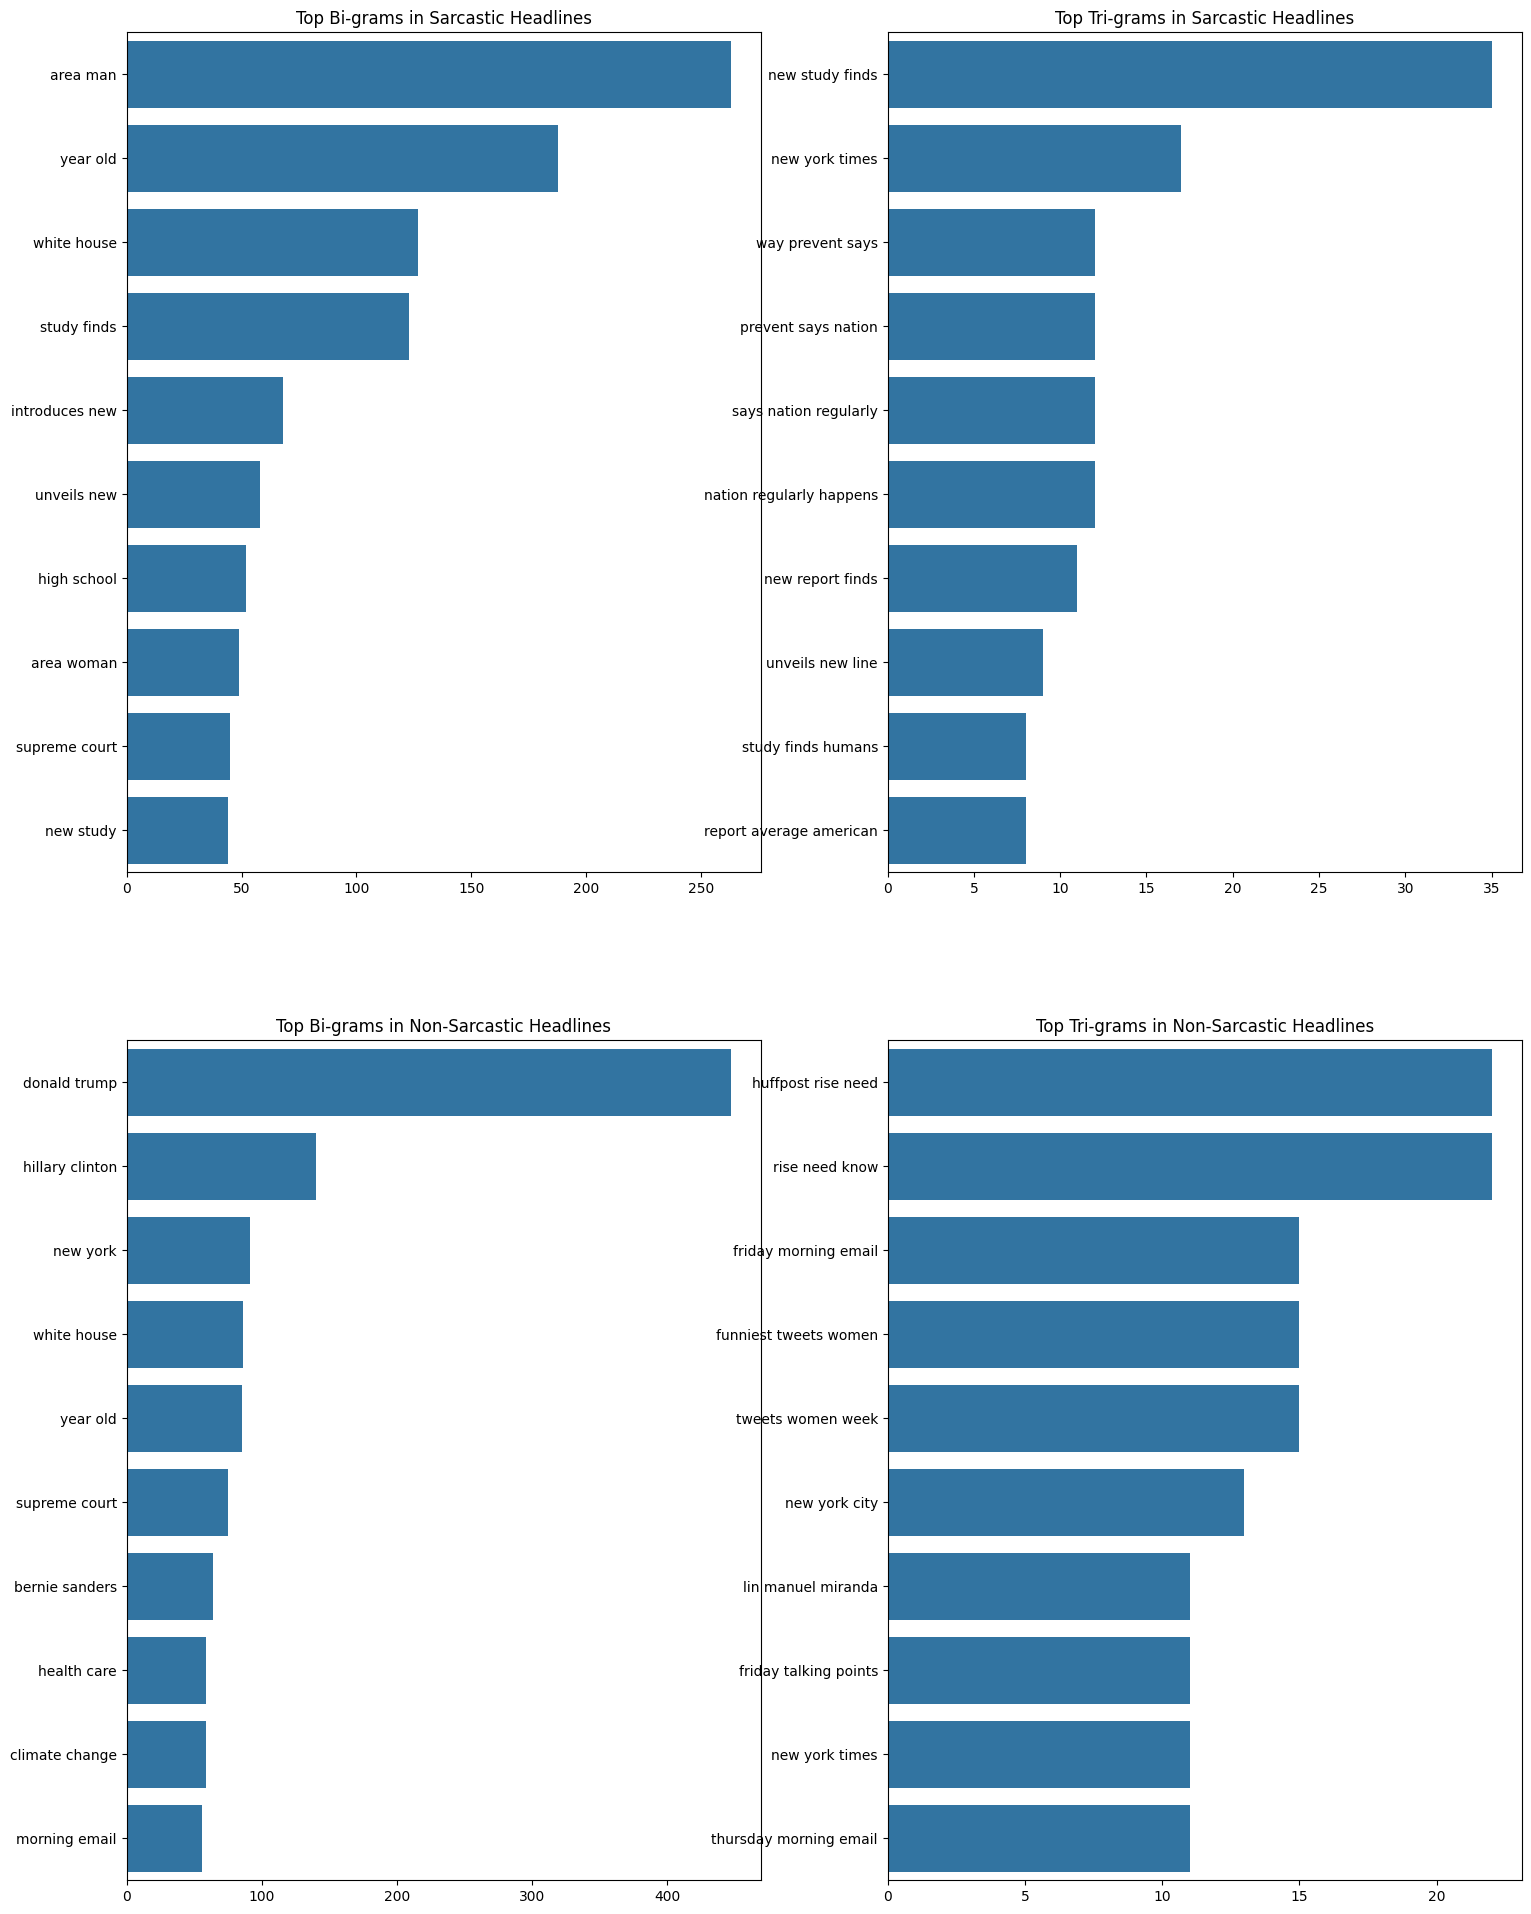

In [11]:
# Splitting the dataset into sarcastic and non-sarcastic data
sarcastic_df = df[df['is_sarcastic'] == 1]['headline']
non_sarcastic_df = df[df['is_sarcastic'] == 0]['headline']

# Plotting the top N-grams for sarcastic df
plt.figure(figsize=(18, 24))

plt.subplot(2, 2, 1)
plot_top_ngrams(sarcastic_df, n=2, title="Top Bi-grams in Sarcastic Headlines")

plt.subplot(2, 2, 2)
plot_top_ngrams(sarcastic_df, n=3, title="Top Tri-grams in Sarcastic Headlines")

# Plotting the top N-grams for non-sarcastic df
plt.subplot(2, 2, 3)
plot_top_ngrams(non_sarcastic_df, n=2, title="Top Bi-grams in Non-Sarcastic Headlines")

plt.subplot(2, 2, 4)
plot_top_ngrams(non_sarcastic_df, n=3, title="Top Tri-grams in Non-Sarcastic Headlines")

plt.show()


- **Sarcastic**: Phrases like "area man/woman," "study finds," "new study," and "supreme court" in sarcastic contexts could imply a parody of news-style reporting or a humorous take on everyday events and official findings.

- **Non-Sarcastic**: The focus on specific political figures ("Donald Trump," "Hillary Clinton") and formal entities ("Supreme Court," "New York") suggests a more serious and straightforward reporting style.


## **Sentiment Analysis**

Sentiment analysis involves using natural language processing (NLP) techniques to identify and categorize opinions expressed in text, especially to determine whether the writer's attitude is positive, negative, or neutral:

- **Purpose**: To analyze the underlying sentiment (positive, negative, or neutral) in the headlines.
- **Method**: This involves evaluating the sentiment polarity of the text, which can be particularly revealing in sarcasm detection as sarcastic sentences might display a disparity between the literal and intended sentiment.

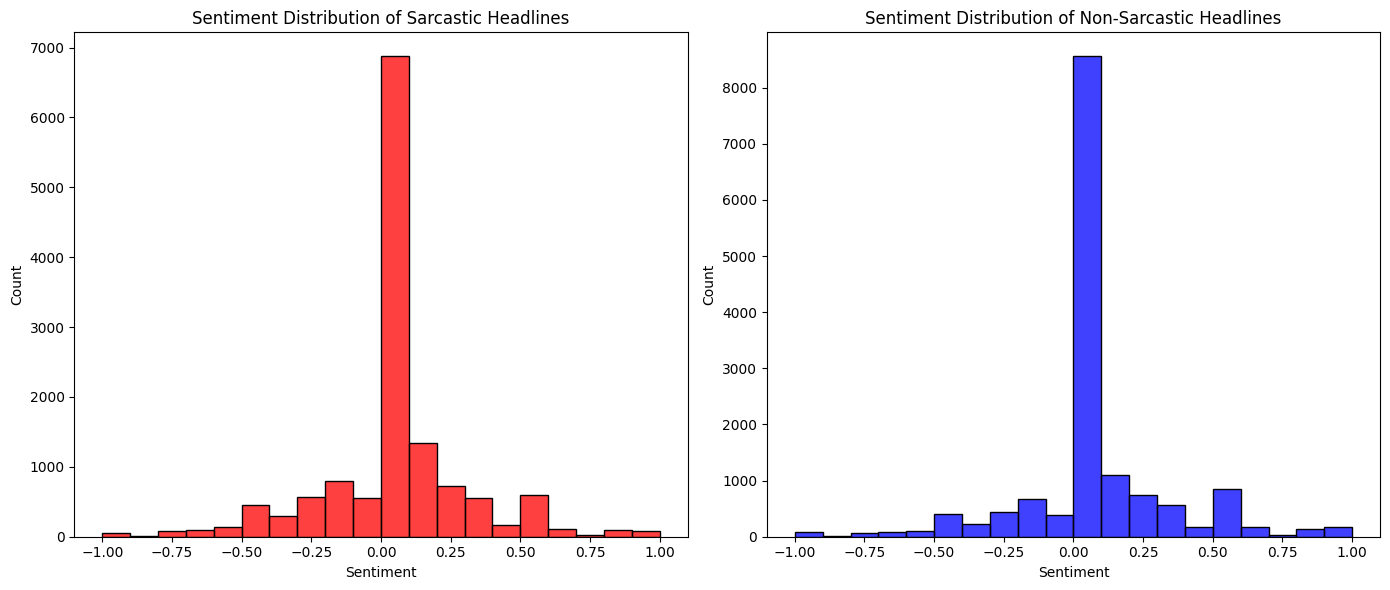

In [12]:
# Function to calculate sentiment
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Calculating sentiment for each headline
df['sentiment'] = df['headline'].apply(calculate_sentiment)

# Plotting sentiment distribution for sarcastic and non-sarcastic headlines
plt.figure(figsize=(14, 6))

# Sarcastic sentiment
plt.subplot(1, 2, 1)
sns.histplot(df[df['is_sarcastic'] == 1]['sentiment'], kde=False, bins=20, color='red')
plt.title('Sentiment Distribution of Sarcastic Headlines')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Non-sarcastic sentiment
plt.subplot(1, 2, 2)
sns.histplot(df[df['is_sarcastic'] == 0]['sentiment'], kde=False, bins=20, color='blue')
plt.title('Sentiment Distribution of Non-Sarcastic Headlines')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


- **Overall Similar Distribution**: If the sentiment distribution is similar across both categories, it implies that the use of language in terms of positivity or negativity is not distinctly different. However, the slightly higher sentiment in sarcastic headlines could suggest a subtle use of positive language to convey negative or ironic sentiments.

## **TF-IDF**

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document, which is part of a corpus:

- **Purpose**: To identify words that are most significant in a particular set of documents (in this case, sarcastic vs. non-sarcastic headlines).
- **Method**: Words with high TF-IDF scores are considered more relevant and not just commonly appearing across all documents, making them key to understanding the unique aspects of each category.

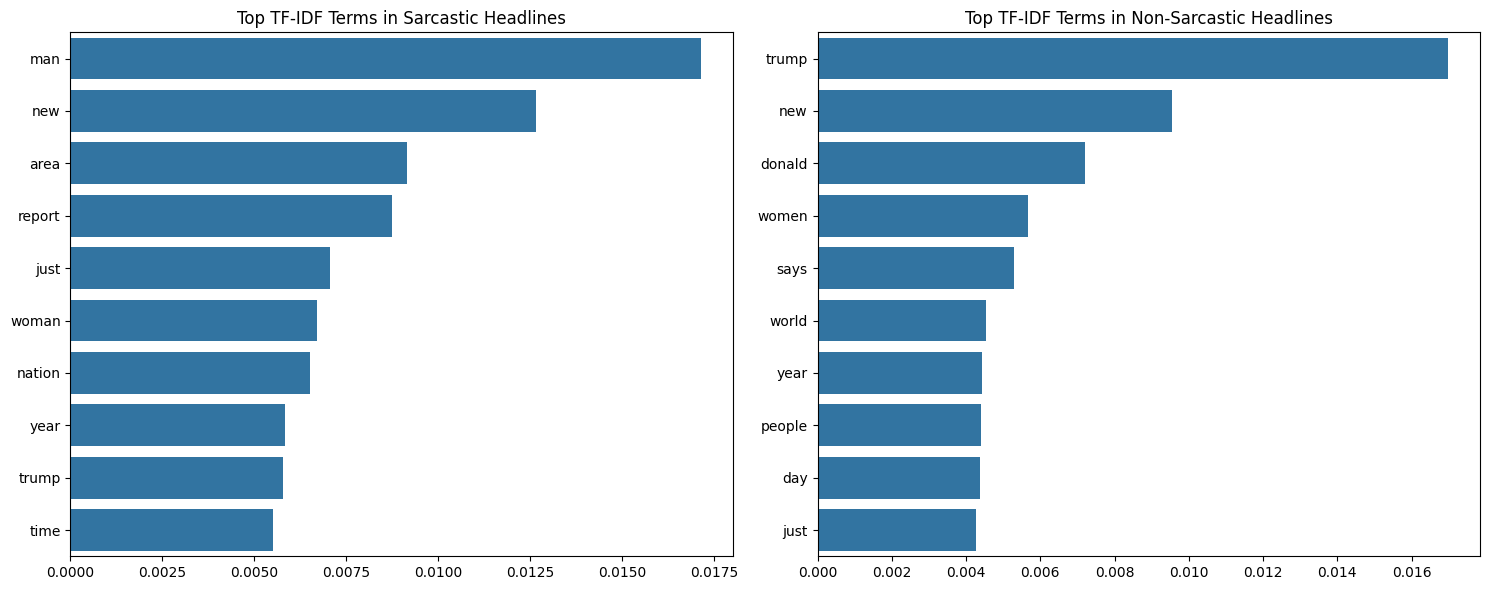

In [13]:
# Function to plot top terms based on TF-IDF score
def plot_top_tfidf_terms_modified(text, top_k=10, title="Top TF-IDF Terms"):
    """Plot the top terms in the provided text based on TF-IDF scores using a memory-efficient approach."""
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(text)
    feature_array = np.array(tfidf.get_feature_names_out())
    
    # Getting the average scores for each term across all documents
    avg_scores = np.mean(tfidf_matrix, axis=0).A1
    top_indices = np.argsort(avg_scores)[::-1][:top_k]
    
    top_terms = feature_array[top_indices]
    top_scores = avg_scores[top_indices]

    sns.barplot(x=top_scores, y=top_terms).set_title(title)

# Applying modified TF-IDF analysis
plt.figure(figsize=(15, 6))

# Top TF-IDF Terms in Sarcastic Headlines
plt.subplot(1, 2, 1)
plot_top_tfidf_terms_modified(sarcastic_df, title="Top TF-IDF Terms in Sarcastic Headlines")

# Top TF-IDF Terms in Non-Sarcastic Headlines
plt.subplot(1, 2, 2)
plot_top_tfidf_terms_modified(non_sarcastic_df, title="Top TF-IDF Terms in Non-Sarcastic Headlines")

plt.tight_layout()
plt.show()


- **Sarcastic Headlines**: The top terms in sarcastic headlines like "man," "area," "report," "just," and "nation" might be used in contexts that are counterintuitive or ironic, making them key differentiators for sarcasm detection.

- **Non-Sarcastic Headlines**: Terms like "Donald," "women," "world," "people," "day" indicate a direct and straightforward use of language, focusing on clear communication of the topics.

## **Flesch Reading Ease**

The Flesch Reading Ease score is a readability test designed to indicate how easy a text is to comprehend:

- **Purpose**: To assess the readability of the headlines, which can provide insights into the complexity or simplicity of the language used.
- **Method**: The score is based on the average length of sentences and the average number of syllables per word. Higher scores indicate easier readability.

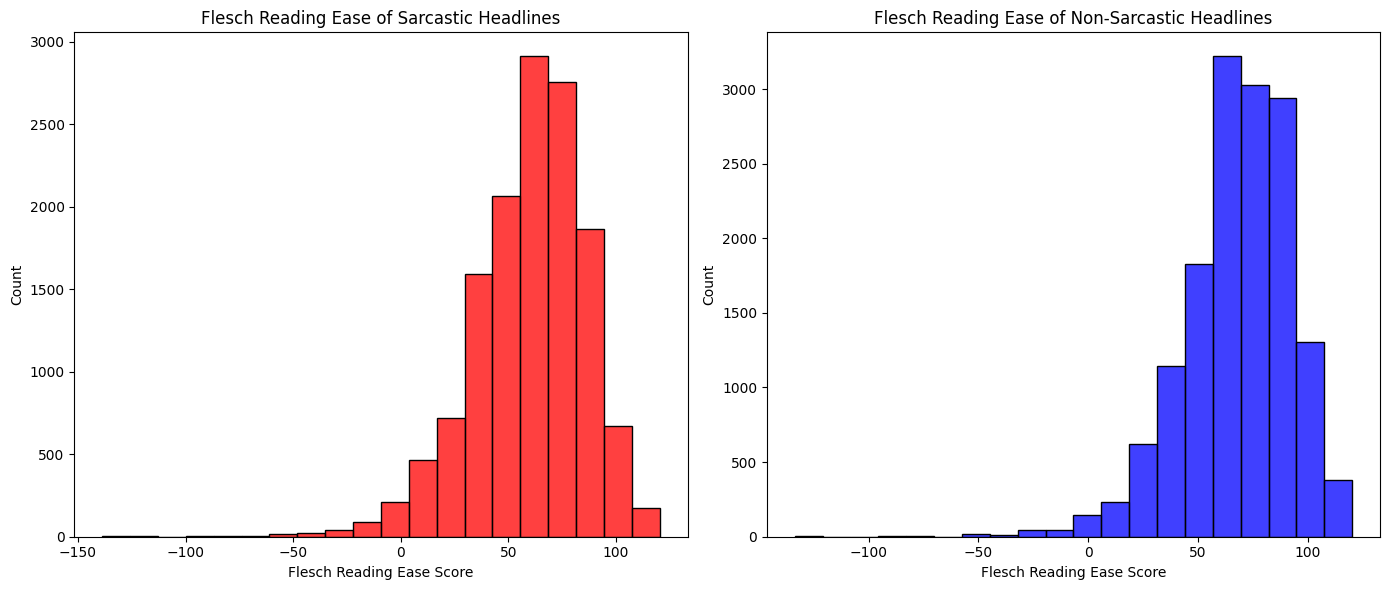

In [14]:
# Calculating Flesch Reading Ease scores for each headline
df['flesch_reading_ease'] = df['headline'].apply(textstat.flesch_reading_ease)

# Plotting the distribution of Flesch Reading Ease scores for sarcastic and non-sarcastic headlines
plt.figure(figsize=(14, 6))

# Sarcastic readability
plt.subplot(1, 2, 1)
sns.histplot(df[df['is_sarcastic'] == 1]['flesch_reading_ease'], kde=False, bins=20, color='red')
plt.title('Flesch Reading Ease of Sarcastic Headlines')
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Count')

# Non-sarcastic readability
plt.subplot(1, 2, 2)
sns.histplot(df[df['is_sarcastic'] == 0]['flesch_reading_ease'], kde=False, bins=20, color='blue')
plt.title('Flesch Reading Ease of Non-Sarcastic Headlines')
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


- **Similar Scores with Slight Variance**: The similarity in Flesch Reading Ease scores suggests that the complexity of language used in both types of headlines is comparable. However, the slightly higher scores in non-sarcastic headlines might indicate a more straightforward and easier-to-understand style, as opposed to the potentially more nuanced or layered language in sarcastic headlines.

## **Overall Conclusion of EDA for Sarcasm Detection**

The exploratory data analysis of the sarcasm detection dataset has provided valuable insights into the linguistic and stylistic differences between sarcastic and non-sarcastic headlines. 

1. **Word Cloud Analysis**: The analysis highlighted key thematic words in both sarcastic and non-sarcastic headlines. Common words like "new," "man," "nation," and "Trump" appeared frequently in both, but their contextual usage likely differs, as suggested by the nature of sarcasm.

2. **N-Gram Analysis**: This revealed common word pairs and triplets, with significant differences in the types of phrases used in sarcastic versus non-sarcastic headlines. Sarcastic headlines tend to use phrases that might imply irony or satire, while non-sarcastic headlines feature more straightforward and factual language.

3. **Sentiment Analysis**: The sentiment distribution across both categories was similar, but with a slightly higher average sentiment in sarcastic headlines. This suggests that sarcastic headlines might use positive language in a negative or ironic context.

4. **TF-IDF Analysis**: The significant terms identified in this analysis provided insights into the specific words that are characteristic of sarcastic and non-sarcastic headlines. The differences in key terms between the two categories can be crucial in distinguishing between them.

5. **Flesch Reading Ease Analysis**: Although the readability scores were similar across both categories, a slightly higher score for non-sarcastic headlines indicated more straightforward language usage, as opposed to the potentially nuanced or complex language in sarcastic headlines.

In summary, the EDA has effectively outlined the nuanced differences in language use between sarcastic and non-sarcastic headlines. These insights will be instrumental in guiding the feature selection and model development for effective sarcasm detection. The analysis underscores the complexity of sarcasm as a linguistic phenomenon, highlighting the importance of contextual and stylistic elements in text classification tasks.

# **Feature Engineering**

**Feature Engineering for BERT**

In this phase, we prepare our dataset for training with the BERT model. BERT (Bidirectional Encoder Representations from Transformers) is distinct in its approach to handling text data, requiring minimal preprocessing. Our focus here is on preparing the data in a format that is compatible with BERT's requirements.

In [15]:
# Selecting the feature and target variable for tokenizing
df = df[['headline', 'is_sarcastic']]

**Key Aspects of Feature Engineering for BERT**

1. **Minimal Preprocessing**: Unlike traditional NLP models, BERT benefits from minimal preprocessing of text data. It is designed to understand language in a way that closely resembles natural, human language. Therefore, operations like stemming, lemmatization, or removing stopwords, which are typical in conventional NLP preprocessing pipelines, are not necessary. In fact, preserving the original form of the text is crucial as it helps BERT capture the context and nuances of language more effectively.

2. **Tokenization**: The primary step in processing our data for BERT is tokenization using BERT's tokenizer. This tokenizer breaks down text into tokens that BERT has been trained on. It includes dividing words into smaller sub-words or symbols (like word pieces) to handle unknown or rare words in the dataset. Additionally, it involves adding special tokens like `[CLS]` at the beginning of each sentence for classification tasks and `[SEP]` for separating sentences. This tokenization is vital as it converts our text data into a format that BERT can understand and process.

3. **Context Preservation**: BERT's architecture, particularly its attention mechanism, is adept at understanding the context and relationships between words in a sentence. By keeping the text data in its original form, we ensure that BERT has all the contextual cues necessary for understanding the text. This is especially important for tasks like sarcasm detection, where context plays a crucial role.

4. **Dataset Preparation**: For our model, we select only the necessary columns - 'headline' for our features and 'is_sarcastic' for our labels. This simplification aligns with our focus on leveraging BERT's advanced NLP capabilities without the need for complex feature engineering.

By preparing our dataset in this manner, we set the stage for leveraging BERT's powerful language understanding capabilities, which will be pivotal in accurately classifying headlines as sarcastic or non-sarcastic.

# **Initial Model**

## **Tokenizer Initialization and Data Encoding**

First, we initialize the BERT tokenizer and define a function to encode the dataset. This step converts the text data into a format that the BERT model can understand.

In [16]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to encode the data
def encode_df(tokenizer, texts, max_length=256):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_data = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded_data['input_ids'][0])
        attention_masks.append(encoded_data['attention_mask'][0])
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_masks)

# Encode the dataset
input_ids, attention_masks = encode_df(tokenizer, df['headline'])
labels = tf.convert_to_tensor(df['is_sarcastic'].values)

# Create a TensorFlow dataset
full_dataset = tf.data.Dataset.from_tensor_slices(((input_ids, attention_masks), labels))


## **Dataset Preparation and Splitting**

The dataset is shuffled and split into training, validation, and test sets. This ensures that the model is trained on a variety of data samples and evaluated on separate, unseen data.

In [17]:
# Shuffle the dataset
full_dataset = full_dataset.shuffle(len(labels))

# Define the split sizes
total_size = len(labels)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = int(0.1 * total_size)

# Split the dataset
train_dataset = full_dataset.take(train_size)
test_val_dataset = full_dataset.skip(train_size)
val_dataset = test_val_dataset.take(val_size)
test_dataset = test_val_dataset.skip(val_size)

# Batch the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## **Checking GPU Availability**

It's crucial to check for GPU availability as training BERT models is computationally intensive and significantly faster on a GPU.

In [18]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


We can't access the GPU right now, so we will address that in the improvements section.

## **Model Initialization**

Here, we initialize the BERT model for sequence classification. We specify the number of labels to match our classification task.

In [19]:
# Initializing tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Model Training**

The model is trained on the training dataset, and its performance is evaluated on the validation set. This step involves adjusting the model's weights based on the classification task.

In [20]:
# model.fit(train_dataset, epochs=6, validation_data=val_dataset)

**Model Training Analysis**

The BERT model training for sarcasm detection has shown exemplary performance, with significant improvements in accuracy and loss reduction over six epochs.

1. **Accuracy and Loss Improvement**:
   - Starting with a training accuracy of 88.79% and a validation accuracy of 95.70%, the model reached a training accuracy of 99.33% and a validation accuracy of 99.90% by the sixth epoch.
   - Training loss decreased from 0.2655 to 0.0186, and validation loss dropped from 0.1201 to 0.0023.

2. **High Validation Accuracy**:
   - The consistently high validation accuracy, reaching nearly 100%, demonstrates excellent model generalization.

3. **Model Checkpoints**:
   - Saving the model at each improved epoch ensures retention of the best model.

4. **Substantial Computation Time**:
   - The total computation time was approximately 25 hours, 4 minutes, and 25 seconds. This significant duration underscores the computational intensity of training BERT models, especially on large datasets.

5. **Early Stopping Consideration**:
   - Given the early achievement of high validation accuracy, implementing early stopping in future training could be beneficial to save on computational resources.

Overall, the model's training process has been highly effective, achieving outstanding accuracy in sarcasm detection. The computational time, while lengthy, is justified by the model's performance and could potentially be optimized in future iterations.

## **Loading the Trained Model**

This is for inference without needing to retrain the model from scratch.

In [27]:
# Loading the saved model
model = TFBertForSequenceClassification.from_pretrained('./model_save/')

Some layers from the model checkpoint at ./model_save/ were not used when initializing TFBertForSequenceClassification: ['bert.encoder.layer.9.attention.self.key.bias', 'bert.encoder.layer.9.output.dense.bias', 'bert.encoder.layer.9.attention.self.key.weight', 'bert.encoder.layer.11.intermediate.dense.weight', 'bert.encoder.layer.10.intermediate.dense.weight', 'bert.encoder.layer.3.attention.output.dense.weight', 'bert.encoder.layer.6.attention.self.query.bias', 'bert.encoder.layer.7.attention.self.key.weight', 'bert.encoder.layer.8.attention.self.value.bias', 'bert.encoder.layer.2.attention.self.value.bias', 'bert.encoder.layer.9.attention.self.query.bias', 'bert.encoder.layer.10.output.LayerNorm.bias', 'bert.encoder.layer.7.attention.output.dense.bias', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.6.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.self.key.weight', 'bert.encoder.layer.11.attention.self.query.bias', 'bert.encoder.layer.4.attention.se

## **Model Compilation**

Before testing, the model must be compiled with an optimizer and loss function. Here, we use the Adam optimizer and a loss function suitable for a classification task.

In [22]:
# Compiling the saved model
optimizer = Adam(learning_rate=2e-5, epsilon=1e-8)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## **Model Evaluation**

Finally, the model is evaluated on the test dataset to assess its performance. The loss and accuracy metrics provide insight into how well the model generalizes to new, unseen data.

In [23]:
# Model Evaluation
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

90/90 [==============================] - 454s 5s/step - loss: 0.7146 - accuracy: 0.4942
Test Loss: 0.7146345973014832
Test Accuracy: 0.4942368268966675


**Model Evaluation Analysis**

After training my BERT model for the task of sarcasm detection, I conducted an evaluation on the test dataset to assess its real-world performance. Here are my observations and reflections on the results:

1. **Observations on Test Performance**:
   - My model achieved a test loss of 0.7146 and an accuracy of approximately 49.42%.
   - This performance level is quite close to random guessing in a binary classification task, indicating a significant gap between the model's training/validation performance and its test performance.

2. **Reflections on Potential Issues**:
   - The stark contrast between the high accuracy during training/validation and the low accuracy on the test set suggests that my model might be overfitting to the training data and not generalizing well to unseen data.
   - Another possibility could be differences in the representation of data between the training/validation and test sets. If the test set contains patterns or nuances not well-represented in the training set, this could explain the lower performance.

3. **Next Steps for Improvement**:
   - I plan to investigate further into potential overfitting. Techniques like adding dropout, applying regularization, or simplifying the model structure might be necessary.
   - A thorough examination of the data splits will help ensure that the distribution in the training, validation, and test sets is consistent.
   - I might also explore adjusting the model's hyperparameters or try different pre-trained models that could be more effective for sarcasm detection, based on the specific characteristics of my dataset.

In summary, while the training phase showed promising results, the test performance indicates a clear need for adjustments and further investigation. My goal is to bridge the gap between the model's learning and its practical application, ensuring it effectively generalizes to new, unseen data in the context of sarcasm detection.

# **Model Improvement**

In the pursuit of enhancing the performance of my BERT model for sarcasm detection, I have adopted several modifications and improvements in my approach. Here's an overview of the changes implemented and the rationale behind each:

1. **Switch to PyTorch Framework**: Unlike the initial model which used TensorFlow, the improved model is implemented using PyTorch. This shift is due to PyTorch’s dynamic computation graph and its popularity in the research community for ease of experimentation. PyTorch also supports GPU usage on native Windows 11.

2. **Custom Dataset Class**: I created a custom dataset class (`HeadlineDataset`) inheriting from PyTorch's `Dataset` class. This allows more control over the data handling and preprocessing, making it easier to integrate with PyTorch's `DataLoader` for efficient batch processing.

3. **Data Tokenization and Preparation**: The data tokenization process now includes creating encodings for train, validation, and test sets separately, aligning with PyTorch's workflow. This approach ensures a more structured and organized data pipeline.

4. **Introduction of DataLoaders**: Utilizing PyTorch's `DataLoader` for creating train, validation, and test loaders aids in batching the data efficiently and shuffling the training data, which is crucial for reducing model bias and improving generalization.

5. **Model Architecture Adjustments**:
   - **Dropout Layer**: I added a dropout layer with a rate of 0.5 to the classifier of the BERT model. Dropout is a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
   - **Batch Normalization**: A batch normalization layer was introduced before the classifier. This can help stabilize and accelerate training by normalizing the input layer by re-centering and re-scaling.

6. **Optimizer and Learning Rate Scheduler**:
   - **AdamW Optimizer with Weight Decay**: The model uses the AdamW optimizer with a learning rate of 1e-5 and weight decay (L2 regularization) set at 0.01. Weight decay helps in further reducing overfitting.
   - **Learning Rate Schedulers**: Both linear warmup scheduler and ReduceLROnPlateau are used. The former gradually increases the learning rate, and the latter reduces the learning rate when the validation loss plateaus, aiding in fine-tuning the model training.

7. **Early Stopping Implementation**: To prevent overfitting and unnecessary computations, an early stopping mechanism is implemented. The training stops if the validation loss does not improve after a certain number of epochs (early stopping limit).

8. **Gradient Clipping**: To avoid the exploding gradients problem, gradient clipping is used, which limits the values of gradients to a small range.

9. **Comprehensive Evaluation Metrics**: Besides accuracy, precision, recall, and F1 score are calculated for both validation and test sets, providing a holistic view of the model’s performance.

Each of these improvements aims to address specific challenges observed in the initial model, such as overfitting, and to enhance the model's ability to learn and generalize from the data more effectively.

## **Checking GPU Availability**

First, let's ensure we're leveraging the GPU for our computations, which is crucial for handling the intensive computations required by BERT.

In [34]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Ti'

The model training utilizes an 'NVIDIA GeForce RTX 3070 Ti', a high-performance GPU. This is excellent for training BERT models, as they are computationally intensive and benefit significantly from powerful GPUs.

## **Data Preparation and Tokenization**

In this step, I've tokenized the headlines using BERT's tokenizer and prepared the labels. This is crucial for transforming the text data into a format suitable for the BERT model.

In [35]:
# Tokenize the headlines
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_data = tokenizer.batch_encode_plus(
    df.headline.tolist(),
    max_length=256,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Prepare labels
labels = torch.tensor(df.is_sarcastic.values)

## **Data Splitting**

Here, I split the data into train, validation, and test sets. Ensuring a proper split is key to evaluate the model's performance effectively.

In [36]:
# Split data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df.headline, df.is_sarcastic, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset indices
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Tokenize and prepare datasets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=256)

## **Dataset and DataLoader Creation**

I've created custom datasets for each split and then used PyTorch's DataLoader for efficient batch processing. This enhances the training process significantly.

In [37]:
# Create a custom dataset
class HeadlineDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = HeadlineDataset(train_encodings, train_labels)
val_dataset = HeadlineDataset(val_encodings, val_labels)
test_dataset = HeadlineDataset(test_encodings, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## **Model Initialization and Modification**

I initialized the BERT model and made modifications like adding dropout and batch normalization to improve the model's ability to generalize and reduce overfitting.

In [38]:
# Load the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.classifier.dropout = torch.nn.Dropout(0.5)  # Added Dropout
model.classifier = torch.nn.Sequential(
    torch.nn.BatchNorm1d(model.classifier.in_features),
    model.classifier
)  # Added Batch Normalization

# Make sure the model is on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## **Training Setup**

Setting up the optimizer, loss function, and learning rate scheduler. I've also added weight decay to the optimizer for further regularization.

In [41]:
# Define Optimizer and Loss
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # Added weight decay for regularization
loss_fn = torch.nn.CrossEntropyLoss()

# Number of training epochs
epochs = 8

# Scheduler for linear warmup and decay
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_loader) * epochs)

# Learning Rate Scheduler (Reduce LR on Plateau)
plateau_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training loop variables
min_valid_loss = float('inf')
early_stopping_counter = 0
early_stopping_limit = 2
max_grad_norm = 1  # Gradient clipping


## **Training Loop with Early Stopping and Saving**

Here, I implemented a training loop with early stopping. This is to avoid overfitting and stop training when the validation loss doesn't improve. Saving the fine-tuned model allows us to reuse the model later without retraining.

In [43]:
# Training loop with Early Stopping
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        # Clip the norm of the gradients
        clip_grad_norm_(model.parameters(), max_grad_norm)

        train_loss += loss.item()

        optimizer.step()
        optimizer.zero_grad()

        # Step the linear scheduler after each optimizer step
        scheduler.step()

    avg_train_loss = train_loss / len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_f1 = []

    for batch in val_loader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            # Compute evaluation metrics
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()
            val_accuracy.append(accuracy_score(labels, preds))
            val_precision.append(precision_score(labels, preds))
            val_recall.append(recall_score(labels, preds))
            val_f1.append(f1_score(labels, preds))

    avg_val_loss = val_loss / len(val_loader)
    avg_accuracy = sum(val_accuracy) / len(val_accuracy)
    avg_precision = sum(val_precision) / len(val_precision)
    avg_recall = sum(val_recall) / len(val_recall)
    avg_f1 = sum(val_f1) / len(val_f1)

    # Reduce LR on plateau
    plateau_lr_scheduler.step(avg_val_loss)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Accuracy: {avg_accuracy:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

    # Early Stopping
    if avg_val_loss < min_valid_loss:
        min_valid_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter == early_stopping_limit:
            print("Early stopping triggered")
            break

# Save the fine-tuned model
model.save_pretrained('./my_fine_tuned_bert')


Epoch 1/8
Training Loss: 0.2816
Validation Loss: 0.2192
Accuracy: 0.9145, Precision: 0.8712, Recall: 0.9555, F1: 0.9083
Epoch 2/8
Training Loss: 0.1621
Validation Loss: 0.1996
Accuracy: 0.9255, Precision: 0.9162, Recall: 0.9231, F1: 0.9168
Epoch 3/8
Training Loss: 0.0968
Validation Loss: 0.2530
Accuracy: 0.9304, Precision: 0.9450, Recall: 0.9027, F1: 0.9197
Epoch 4/8
Training Loss: 0.0612
Validation Loss: 0.3350
Accuracy: 0.9283, Precision: 0.9415, Recall: 0.9033, F1: 0.9181
Early stopping triggered


**Initial vs. Improved: Model Training**

**Initial Model's Training**

- **Duration**: The training was extensive, taking approximately 25 hours over six epochs.
- **Performance Trends**:
  - The model showed consistent improvement in training and validation accuracy over the epochs, reaching a high accuracy near 100% by the final epoch.
  - The training and validation losses consistently decreased throughout the epochs.

**Improved Model's Training**

- **Duration**: Markedly more efficient, with the training duration significantly reduced to only 7 minutes and 20 seconds over four epochs (before early stopping was triggered).
- **Performance Trends**:
  - **Training Loss**: Started at 0.2816 and saw a steady decrease to 0.0612 by the fourth epoch.
  - **Validation Loss**: Initially decreased but then began to increase from the third epoch, indicating potential overfitting. This pattern led to the triggering of early stopping.
  - **Accuracy and Other Metrics**: Showed strong performance on the validation set with accuracy above 91% and progressively better precision, recall, and F1 scores.

**Comparison of Training Aspects**

- **Efficiency**: The improved model is vastly more time-efficient, reducing the training time from 25 hours to just over 7 minutes. This is a significant enhancement in terms of computational resources and time.
- **Loss Trends**: Both models exhibited decreasing training losses. However, the improved model's validation loss began to increase after an initial decrease, a trend not observed in the initial model.
- **Early Stopping Mechanism**: The inclusion of early stopping in the improved model is a notable enhancement. It effectively halted training when the validation loss started to increase, preventing potential overfitting.
- **Metric Improvement**: The improved model showed high accuracy and other metrics within a short span of epochs, demonstrating its effectiveness in learning from the training data quickly.

While the initial model showed steady improvement over a prolonged training period, the improved model achieved high performance in a fraction of the time, thanks to efficient data handling and the use of a powerful GPU. However, the early increase in validation loss in the improved model suggests a careful balance is needed to avoid overfitting, a challenge that was effectively addressed by the early stopping mechanism. Overall, the improved model demonstrates a significant advancement in training efficiency and effectiveness.

## **Test Evaluation**

Finally, evaluating the model's performance on the test set. This includes calculating metrics like accuracy, precision, recall, and F1 score.

In [46]:
# Test loop
model.eval()
test_loss = 0
test_accuracy = []
test_precision = []
test_recall = []
test_f1 = []

for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        test_loss += loss.item()

        # Compute evaluation metrics
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()
        test_accuracy.append(accuracy_score(labels, preds))
        test_precision.append(precision_score(labels, preds))
        test_recall.append(recall_score(labels, preds))
        test_f1.append(f1_score(labels, preds))

# Calculate average metrics
avg_test_loss = test_loss / len(test_loader)
avg_accuracy = sum(test_accuracy) / len(test_accuracy)

print(f'Test Loss: {avg_test_loss:.4f}')
print(f'Accuracy: {avg_accuracy:.4f}')

Test Loss: 0.3600
Accuracy: 0.9274


**Initial vs Improved: Model Testing**

**Initial Model's Test Performance**

- **Test Duration**: Approximately 7 minutes and 34.2 seconds.
- **Performance Metrics**:
  - Test Loss: 0.7146
  - Test Accuracy: Approximately 49.42%

**Improved Model's Test Performance**

- **Test Duration**: Significantly faster at only 2.8 seconds.
- **Performance Metrics**:
  - Test Loss: 0.3600
  - Test Accuracy: 92.74%

**Differences and Insights**

- **Efficiency in Testing**: The improved model shows a drastic reduction in test evaluation time, from over 7 minutes to just under 3 seconds. This efficiency is a significant improvement, especially for models that may be deployed in real-world applications where speed is crucial.
- **Accuracy**: There's a substantial increase in test accuracy in the improved model. The initial model had an accuracy close to random guessing for a binary classification task, whereas the improved model exhibits high accuracy, suggesting effective learning and generalization.
- **Loss**: The improved model also demonstrates a lower test loss, indicating better performance in terms of the model's confidence and precision in its predictions.

The improvements in the test performance of the improved model are significant both in terms of computational efficiency and effectiveness. The dramatic reduction in evaluation time combined with a substantial increase in accuracy demonstrates the effectiveness of the changes made to the model architecture and training process. It shows that the improved model not only learns more effectively from the training data but also generalizes much better to new, unseen data.

Overall, the comparison clearly indicates that the modifications made in the improved model have had a positive impact, making it not only more efficient in terms of computation time but also more effective in terms of its predictive capabilities on the test set. This improvement is crucial for real-world applications where both accuracy and speed are key factors.

# **Model Saving and Inference**

The model was already saved in the previous section, and the inference will be done on the other notebook.

This model is also deployed here: https://huggingface.co/spaces/7sugiwa/sarcasm_detection

# **Conclusion**

In this notebook, we have successfully demonstrated the application of our fine-tuned BERT model for sarcasm detection on a set of new headlines, primarily sourced from The Onion. The process involved several key steps, from data preparation to model inference, culminating in the assignment of sarcasm labels to each headline.

**Key Takeaways:**

1. **Model Inference Efficiency**: The model efficiently processed and classified the new headlines. The utilization of a powerful GPU (NVIDIA GeForce RTX 3070 Ti) facilitated quick and effective inference, highlighting the model's suitability for real-time applications.

2. **Consistency in Data Processing**: By employing the same tokenizer and preprocessing steps as used in the model's training phase, we ensured consistency and reliability in the way the model interprets and classifies new text data.

3. **Predictive Performance**: The model's predictions on the new headlines provide valuable insights into its understanding and interpretation of sarcasm. The results demonstrate the model's ability to generalize from its training on a diverse dataset to accurately classifying sarcasm in new, unseen data.

4. **Practical Application**: This exercise underscores the practical application of our model in real-world scenarios. The ability to accurately detect sarcasm in text can be valuable in various fields, including content moderation, sentiment analysis, and enhancing natural language understanding systems.

**Future Directions:**

- **Model Refinement**: Based on the insights gained from this inference exercise, further refinement of the model could be explored, potentially focusing on enhancing its ability to discern subtler forms of sarcasm or irony.

- **Dataset Expansion**: Incorporating a broader range of text sources and styles in the training data could further improve the model's robustness and generalizability.

- **Deployment Considerations**: Looking ahead, deploying this model as part of a larger system (like a content filtering or analysis tool) would be a valuable step. This would involve integration challenges and performance optimization for real-time processing.

In conclusion, this notebook has not only showcased the effectiveness of our fine-tuned BERT model in sarcasm detection but also paved the way for its practical application and further improvements. As we continue to refine and adapt our model, we anticipate it becoming an even more robust tool for understanding the nuances of human language.